# Unscented Kalman Filter 

The Kalman filter predicts the current state based on the previous state，weighting the predicted state quantity with the measured quantity of the current moment. Only the the weighted result is considered to be the actual current state quantity which can be used to the next iteration. 
The kalman filter is specifically for linear system, and more pratically we can use unscented kalman filter to obtain the more accurate value of the state. The unscented kalman filter also contains the 'prediction' and 'update' process, but with the additional step of generating sigma points. The basic idea is to approximate the random distribution of a non-linear model by sampling from a known distribution.

In [1]:
from IPython.display import Latex

In [2]:
import numpy as np
import scipy
from numpy.random import randn
import numpy as np
from scipy.linalg import sqrtm
import math  
import matplotlib.pyplot as plt

Now we use a simple example to show the performance of the unscented kalman filter. It is no need to ust unsented kalman filter in this example because it is a linear example. But it is easy to read. 

Now we propagate the variable $\textbf{x}$ through a nonlinear function $\textbf{y}$=$g(\textbf{x})$. Assume $\textbf{x}$ has mean $\mu$ and convariance $\Sigma$. To calculate the statistic of $\textbf{y}$, we form a matrix $\boldsymbol{\chi}$.
Some parameters which we can manually set up:$\alpha$, $\beta$. 
When the noise is gaussian distribution,we chose $\alpha=0.01$ and $\beta=2$.
$\kappa$ influence how far the sigma points are away from the mean.
The mean and covariance of the sigma points are computed as:

$$\begin{aligned}
\mu &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal{Y}}_i \\
\Sigma &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal{Y}}_i-\mu)(\boldsymbol{\mathcal{Y}}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

In [3]:
def parameter_sigmapoints(n,alpha,beta,kappa):
    '''
    n : dimension of state vector
    alpha,beta,kappa : manually set up patamaters
    wm : weight matrix for calculating mean
    wc : weight matrix for calculating variance
    U : a parameter for computation convenience 
    '''
    lamb=alpha**2*(n+kappa)-n
    wm=[lamb/(n+lamb)]
    wc=[(lamb/(lamb+n))+(1-alpha**2+beta)]
    for i in range(2*n):
        wm.append(1/(2*(n+lamb)))
        wc.append(1/(2*(n+lamb)))
    U=math.sqrt(n+lamb)
    U=np.array([U])
    wm=np.array([wm])
    wc=np.array([wc])
    return wm,wc,U


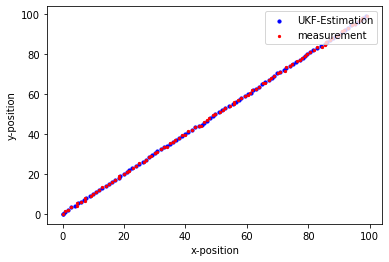

In [12]:


# Observation: x,y position,measurement noise matrix R 
R = np.diag([0.3, 0.3]) ** 2  

# process noise matrix
#np.random.seed()
Q=np.zeros(shape=(4,4))
A = np.random.normal(0, 0.02, size=(2, 2))
Q[2:4, 2:4] =A
Q[0:2,0:2]=A

# f(x)motion model

def f(x,dt):
    """ 
    with constant velocity
    """
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return F @ x  

# h(x) observation model

def h(x):
    ''' 
    the measurements are [x_pos, y_pos]
    '''
    H = np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0]
    ])

    z = H @ x

    return z

#generazation of sigma ponits
def generate_sigmapoints(xEst, PEst, U):
    '''
    xEst:mean of initial data
    PEst:variance of initial data 
    U:U=sqrt(n+lamb)
    '''
    sigma = xEst
    Psqrt = scipy.linalg.sqrtm(PEst)
    #Psqrt=scipy.linalg.cholesky(PEst)
    n = len(xEst[:, 0])
    for i in range(n):
        sigma = np.hstack((sigma, xEst + U * Psqrt[:, i:i + 1]))
    for i in range(n):
        sigma = np.hstack((sigma, xEst - U * Psqrt[:, i:i + 1]))
    return sigma
    

def transform_sigma_motion(sigma):
    """
        Sigma Points prediction with motion model 
    """
    for i in range(sigma.shape[1]):
        sigma[:, i:i + 1] = f(sigma[:, i:i + 1],dt)

    return sigma

def transform_sigma_observation(sigma):
    """
        Sigma Points prediction with observation model
    """
    sigma_obs=np.zeros((2,sigma.shape[1]))
    for i in range(sigma.shape[1]): 
        sigma_obs[:,i] = h(sigma[:, i])
    return sigma_obs

def covariance_prior(x, sigma, wc, Pi):
    ''' 
    
    '''
    nSigma = sigma.shape[1]
    
    d = sigma - x[0:sigma.shape[0]]
    #print('d ist',d)
    P = Pi
    for i in range(nSigma):
        P = P + wc[0, i] * d[:, i:i + 1] @ d[:, i:i + 1].T
    return P


def calc_pxz(sigma, x, z_sigma, zb, wc):
    '''
    
    '''
    nSigma = sigma.shape[1]
    dx = sigma - x
    dz = z_sigma - zb[0:2]
    P = np.zeros((dx.shape[0], dz.shape[0]))

    for i in range(nSigma):
        P = P + wc[0, i] * dx[:, i:i + 1] @ dz[:, i:i + 1].T
    return P

def ukf_estimation(xEst, PEst, z, wm, wc, gamma):
    '''
    z: observation with noise 
    wm, wc, gamma: constant parameters
    '''
    #  Predict process
    # generate sigma points
    sigma = generate_sigmapoints(xEst, PEst, gamma)
    sigma= transform_sigma_motion(sigma)
    #prediction of mean of input 
    xPred = (wm @ sigma.T).T
    # estimate of covariance 
    PPred = covariance_prior(xPred, sigma, wc, Q)
    
    #  Update process
    
    #  generate new sigma points after prediction 
    sigma = generate_sigmapoints(xPred, PPred, gamma)
    # transform sigma points with observation model    
    z_sigma = transform_sigma_observation(sigma)
    # mean
    zPred = (wm @ z_sigma.T).T
    #  Pz_matrix  
    st = covariance_prior(zPred, z_sigma, wc, R)
    Pxz = calc_pxz(sigma, xPred, z_sigma, zPred, wc)
    # kalman gain
    K = Pxz @ np.linalg.inv(st)
    y = z - zPred
    # update the estimate value：  
    xEst = xPred + K @ y
    # update the covariance：
    PEst = PPred - K @ st @ K.T
    return xEst, PEst

#initialize parameters
dt=1
xEst = np.zeros((4, 1)) #default initial state
    
n = 4  # dimension of State Vector [x x_dot y y_dot]'

PEst = np.eye(n) # initial of the covariance matrix 

n=4
alpha=.1
beta=2.
kappa=1. 

wm, wc, gamma = parameter_sigmapoints(n,alpha,beta,kappa)

hxEst = xEst

hz=[]
for i in range(100):
    np.random.seed()
    z=np.array([[i+randn()*.3,i+randn()*.3]]) 
    z=z.T
    hz.append(z)
    xEst, PEst = ukf_estimation(xEst, PEst, z, wm, wc, gamma)
    hxEst = np.hstack((hxEst, xEst)) 
hz = np.array(hz)
f, ax = plt.subplots()
plt.scatter(hxEst[0,:],hxEst[2,:],color='blue',s=10,label="UKF-Estimation")
plt.scatter(hz[:,0],hz[:,1],color='red',s=5,label="measurement")
plt.plot()
plt.xlabel('x-position')
plt.ylabel('y-position')
plt.legend(('UKF-Estimation','measurement'), loc='upper right') 
plt.show()